## Ennek a projektnek a célja az SSD meghajtókat és tulajdonságaikat tartalmazó adathalmaz alapján megjósolni, hogy adott paraméterek mellett várhatóan mennyibe fog kerülni az SSD.

Szükséges könyvtárak

In [255]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

Az adathalmaz

In [256]:
df = pd.read_csv('ssd.csv')

In [257]:
df

,Megnevezés,Méret,Csatlakozás,Technológia,Tároló kapacitás,SSD max írás,SSD max olvasás,TBW,Világítás,Hűtőborda,Ár (FT),Méretek,PCI-e 4.0 SSD
0,"KINGSTON 240GB A400 SATA 3 2.5"" SA400S37/240G","2.5""",SATA 3,TLC,240 GB,350 MB/s,500 MB/s,80 TB,Nem,Nem,11890,NaN,NaN
1,KINGSTON 500GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,500 GB,2000 MB/s,2200 MB/s,300 TB,Nem,Nem,22189,80 x 22 x 3.5 mm,NaN
2,"KINGSTON 480GB A400 SATA 3 2.5"" SA400S37/480G","2.5""",SATA 3,TLC,480 GB,450 MB/s,500 MB/s,160 TB,Nem,Nem,18090,NaN,NaN
3,KINGSTON 250GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,250 GB,1100 MB/s,2000 MB/s,150 TB,Nem,Nem,14489,80 x 22 x 3.5 mm,NaN
4,KINGSTON 1TB A2000 M.2 PCIe M.2 2280 SA2000M8/...,M.2 2280,M.2 PCIe,TLC,1000 GB,2000 MB/s,2200 MB/s,600 TB,Nem,Nem,39590,80 x 22 x 3.5 mm,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,WD 500GB Black SN850 M.2 PCIe M.2 2280 WDBAPY5...,M.2 2280,M.2 PCIe,TLC,500 GB,4100 MB/s,7000 MB/s,300 TB,Nem,Nem,76290,80 x 22 x 2.38 mm,Igen
725,WD 500GB Blue SN550 NVMe M.2 PCIe M.2 2280 WDB...,M.2 2280,M.2 PCIe,TLC,500 GB,1750 MB/s,2400 MB/s,300 TB,Nem,Nem,64690,80 x 22 x 2.38 mm,NaN
726,"ZADAK 128GB TWSS3 SATA 3 2.5"" ZS128GTWSS3-1","2.5""",SATA 3,TLC,128 GB,540 MB/s,560 MB/s,0 TB,Nem,Nem,10690,100 x 69.9 x 7 mm,Nem
727,"ZADAK 256GB TWSS3 SATA 3 2.5"" ZS256GTWSS3-1","2.5""",SATA 3,TLC,256 GB,540 MB/s,560 MB/s,0 TB,Nem,Nem,14089,100 x 69.9 x 7 mm,Nem


Először érdemes értelmezni a különböző adatokat.

A Megnevezés mező tartalmazza az SSD nevét.

A Méret azt, hogy mekkora az SSD mérete.

A Csatlakozás azt mondja el, hogy milyen szabványt használ a meghajtó.

A Tároló kapacítás az SSD tárhelyét mutatja meg.

Az SSD max írás tartalmazza, hogy maximum mekkora sebességgel lehetet adatot írni.

Az SSD max olvasás tartalmazza, hogy maximum mekkora sebességgel lehetet adatot olvasni.

A TBW a gyártó által megadott maximum írási mennyiség amennyit az SSD elbír.

A Világítás azt jelenti rendelkezik-e a termék világítással.

A Hűtőborda azt jelenti rendelkezik-e a termék hűtőbordával.

Az Ár (FT) a termék ára.

A Méretek mutatják meg, hogy a meghajtó milyen fizikai paraméterekkel rendelkezik.

A PCI-e 4.0 SSD azt mondja meg, hogy a termék rendelkezik-e ezzel a technológiával.

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Megnevezés        729 non-null    object
 1   Méret             729 non-null    object
 2   Csatlakozás       729 non-null    object
 3   Technológia       726 non-null    object
 4   Tároló kapacitás  729 non-null    object
 5   SSD max írás      729 non-null    object
 6   SSD max olvasás   729 non-null    object
 7   TBW               729 non-null    object
 8   Világítás         729 non-null    object
 9   Hűtőborda         729 non-null    object
 10  Ár (FT)           729 non-null    int64 
 11  Méretek           481 non-null    object
 12  PCI-e 4.0 SSD     70 non-null     object
dtypes: int64(1), object(12)
memory usage: 74.2+ KB


### Hiányzó értékek

Hiányzó értékek az adathalmazban

In [259]:
df.isnull().sum()

Megnevezés            0
Méret                 0
Csatlakozás           0
Technológia           3
Tároló kapacitás      0
SSD max írás          0
SSD max olvasás       0
TBW                   0
Világítás             0
Hűtőborda             0
Ár (FT)               0
Méretek             248
PCI-e 4.0 SSD       659
dtype: int64

Érdemes megnézni százalékos arányban is.

In [260]:
percent = ((df['Technológia'].isnull().sum() / df.shape[0]) * 100).round(2)
percent

0.41

A Technológia mező elhanyagolhatóan kevés hiányzóértéket tartalmaz

In [261]:
percent = ((df['Méretek'].isnull().sum() / df.shape[0]) * 100).round(2)
percent

34.02

In [262]:
percent = ((df['PCI-e 4.0 SSD'].isnull().sum() / df.shape[0]) * 100).round(2)
percent

90.4

A PCI-e 4.0 SSD mezőnek rengetek értéke hiányzik.

In [263]:
df_droped = df.drop(['Méretek', 'PCI-e 4.0 SSD'], axis=1)
df_droped.dropna(inplace=True, axis=0)
df_droped.reset_index(drop=True, inplace=True)

In [264]:
df_droped.isnull().sum()

Megnevezés          0
Méret               0
Csatlakozás         0
Technológia         0
Tároló kapacitás    0
SSD max írás        0
SSD max olvasás     0
TBW                 0
Világítás           0
Hűtőborda           0
Ár (FT)             0
dtype: int64

In [265]:
df_droped.shape

(726, 11)

### Redundáns adatok

In [266]:
len(df[df.duplicated() == True])

0

Az adathalmaz nem tartalmaz ismétlődő sorokat.

### Refactorálás

A mezők különböző értékei.

In [267]:
for col in df_droped.columns:
    if col != 'Megnevezés' and col != 'Ár (FT)':
        print(col)
        print(df_droped[col].unique())
        print()

Méret
['2.5"' 'M.2 2280' 'mSATA' 'M.2 2242' 'HHHL/PCI Express' 'M.2 2230'
 'M.2 2260' 'Half Slim']

Csatlakozás
['SATA 3' 'M.2 PCIe' 'mSATA' 'M.2 SATA' 'PATA/IDE' 'PCI Express' 'SATA 2']

Technológia
['TLC' 'MLC' 'Optane' 'QLC']

Tároló kapacitás
['240 GB' '500 GB' '480 GB' '250 GB' '1000 GB' '256 GB' '32 GB' '120 GB'
 '960 GB' '512 GB' '2000 GB' '128 GB' '4000 GB' '64 GB' '8000 GB'
 '1920 GB' '3840 GB' '60 GB' '16 GB']

SSD max írás
['350 MB/s' '2000 MB/s' '450 MB/s' '1100 MB/s' '3200 MB/s' '2700 MB/s'
 '650 MB/s' '40 MB/s' '530 MB/s' '500 MB/s' '520 MB/s' '320 MB/s'
 '2300 MB/s' '3300 MB/s' '510 MB/s' '465 MB/s' '380 MB/s' '3000 MB/s'
 '298 MB/s' '5000 MB/s' '1000 MB/s' '950 MB/s' '420 MB/s' '1700 MB/s'
 '2600 MB/s' '430 MB/s' '1925 MB/s' '455 MB/s' '1550 MB/s' '1800 MB/s'
 '460 MB/s' '490 MB/s' '2100 MB/s' '1950 MB/s' '4250 MB/s' '515 MB/s'
 '1600 MB/s' '375 MB/s' '2400 MB/s' '540 MB/s' '1750 MB/s' '1200 MB/s'
 '400 MB/s' '1900 MB/s' '480 MB/s' '300 MB/s' '1500 MB/s' '470 MB/s'
 '41

Láthatóan nincsenenk inkonzisztens adataink, azonban több helyen is numerikus adatokkal szeretnénk számolni a továbbiakban, ezért ezeknek a mezőknek az értékeit formázni kell.

In [268]:
for i in range(df_droped.shape[0]):
    df_droped.loc[i, 'Tároló kapacitás'] = df_droped.loc[i, 'Tároló kapacitás'].replace(' GB', '')
    df_droped.loc[i, 'SSD max írás'] = df_droped.loc[i, 'SSD max írás'].replace(' MB/s', '')
    df_droped.loc[i, 'SSD max olvasás'] = df_droped.loc[i, 'SSD max olvasás'].replace(' MB/s', '')
    df_droped.loc[i, 'TBW'] = df_droped.loc[i, 'TBW'].replace(' TB', '')

df_droped.rename(columns={'Tároló kapacitás': 'Tároló kapacitás (GB)'}, inplace=True)
df_droped.rename(columns={'SSD max írás': 'SSD max írás (MB/s)'}, inplace=True)
df_droped.rename(columns={'SSD max olvasás': 'SSD max olvasás (MB/s)'}, inplace=True)
df_droped.rename(columns={'TBW': 'TBW (TB)'}, inplace=True)

In [269]:
for col in df_droped.columns:
    if col != 'Megnevezés' and col != 'Ár (FT)':
        print(col)
        print(df_droped[col].unique())
        print()

Méret
['2.5"' 'M.2 2280' 'mSATA' 'M.2 2242' 'HHHL/PCI Express' 'M.2 2230'
 'M.2 2260' 'Half Slim']

Csatlakozás
['SATA 3' 'M.2 PCIe' 'mSATA' 'M.2 SATA' 'PATA/IDE' 'PCI Express' 'SATA 2']

Technológia
['TLC' 'MLC' 'Optane' 'QLC']

Tároló kapacitás (GB)
['240' '500' '480' '250' '1000' '256' '32' '120' '960' '512' '2000' '128'
 '4000' '64' '8000' '1920' '3840' '60' '16']

SSD max írás (MB/s)
['350' '2000' '450' '1100' '3200' '2700' '650' '40' '530' '500' '520'
 '320' '2300' '3300' '510' '465' '380' '3000' '298' '5000' '1000' '950'
 '420' '1700' '2600' '430' '1925' '455' '1550' '1800' '460' '490' '2100'
 '1950' '4250' '515' '1600' '375' '2400' '540' '1750' '1200' '400' '1900'
 '480' '300' '1500' '470' '410' '550' '440' '4400' '2500' '2200' '425'
 '1050' '1150' '940' '445' '67' '200' '4100' '1400' '5300' '900' '880'
 '1880' '2900' '1300' '600' '3080' '800' '310' '5100' '6400' '495' '5500'
 '1625' '475' '360' '3100' '850' '485' '205' '1650' '525' '3700' '6550'
 '3950' '0' '523' '2250' '1250'

Végül az adatokat numerikus típussá alakítjuk.

In [270]:
num_cols = ['Tároló kapacitás (GB)', 'SSD max írás (MB/s)', 'SSD max olvasás (MB/s)', 'TBW (TB)']

for col in num_cols:
    df_droped[col] = pd.to_numeric(df_droped[col])

In [271]:
df_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Megnevezés              726 non-null    object
 1   Méret                   726 non-null    object
 2   Csatlakozás             726 non-null    object
 3   Technológia             726 non-null    object
 4   Tároló kapacitás (GB)   726 non-null    int64 
 5   SSD max írás (MB/s)     726 non-null    int64 
 6   SSD max olvasás (MB/s)  726 non-null    int64 
 7   TBW (TB)                726 non-null    int64 
 8   Világítás               726 non-null    object
 9   Hűtőborda               726 non-null    object
 10  Ár (FT)                 726 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 62.5+ KB


A formázás után könnyebben észrevehető, hogy vannak olyan értékek, amik bár nem minősülnek hiányzó adatnak, de nincsenek mérve. Az SSD max írás (MB/s), SSD max olvasás (MB/s) és a TBW (TB) mezők tartalmaznak 0 értékeket.

Lássuk mennyi értéket tesznek ki az egész adathalmazból.

In [272]:
len(df_droped[df_droped['SSD max írás (MB/s)'] == 0])

6

In [273]:
len(df_droped[df_droped['SSD max olvasás (MB/s)'] == 0])

4

In [274]:
len(df_droped[df_droped['TBW (TB)'] == 0])

224

In [275]:
len(df_droped[(df_droped['SSD max írás (MB/s)'] == 0) | (df_droped['SSD max olvasás (MB/s)'] == 0) | (df_droped['TBW (TB)'] == 0)])

226

In [276]:
df_droped.drop('TBW (TB)', inplace=True, axis=1)
df_droped.shape

(726, 10)

In [277]:
indexes = df_droped[(df_droped['SSD max írás (MB/s)'] == 0) | (df_droped['SSD max olvasás (MB/s)'] == 0)].index
df_droped = df_droped.drop(indexes)
df_droped.reset_index(drop=True, inplace=True)

In [278]:
df_droped

,Megnevezés,Méret,Csatlakozás,Technológia,Tároló kapacitás (GB),SSD max írás (MB/s),SSD max olvasás (MB/s),Világítás,Hűtőborda,Ár (FT)
0,"KINGSTON 240GB A400 SATA 3 2.5"" SA400S37/240G","2.5""",SATA 3,TLC,240,350,500,Nem,Nem,11890
1,KINGSTON 500GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,500,2000,2200,Nem,Nem,22189
2,"KINGSTON 480GB A400 SATA 3 2.5"" SA400S37/480G","2.5""",SATA 3,TLC,480,450,500,Nem,Nem,18090
3,KINGSTON 250GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,250,1100,2000,Nem,Nem,14489
4,KINGSTON 1TB A2000 M.2 PCIe M.2 2280 SA2000M8/...,M.2 2280,M.2 PCIe,TLC,1000,2000,2200,Nem,Nem,39590
...,...,...,...,...,...,...,...,...,...,...
715,WD 500GB Black SN850 M.2 PCIe M.2 2280 WDBAPY5...,M.2 2280,M.2 PCIe,TLC,500,4100,7000,Nem,Nem,76290
716,WD 500GB Blue SN550 NVMe M.2 PCIe M.2 2280 WDB...,M.2 2280,M.2 PCIe,TLC,500,1750,2400,Nem,Nem,64690
717,"ZADAK 128GB TWSS3 SATA 3 2.5"" ZS128GTWSS3-1","2.5""",SATA 3,TLC,128,540,560,Nem,Nem,10690
718,"ZADAK 256GB TWSS3 SATA 3 2.5"" ZS256GTWSS3-1","2.5""",SATA 3,TLC,256,540,560,Nem,Nem,14089


### Outlierek

<AxesSubplot:>

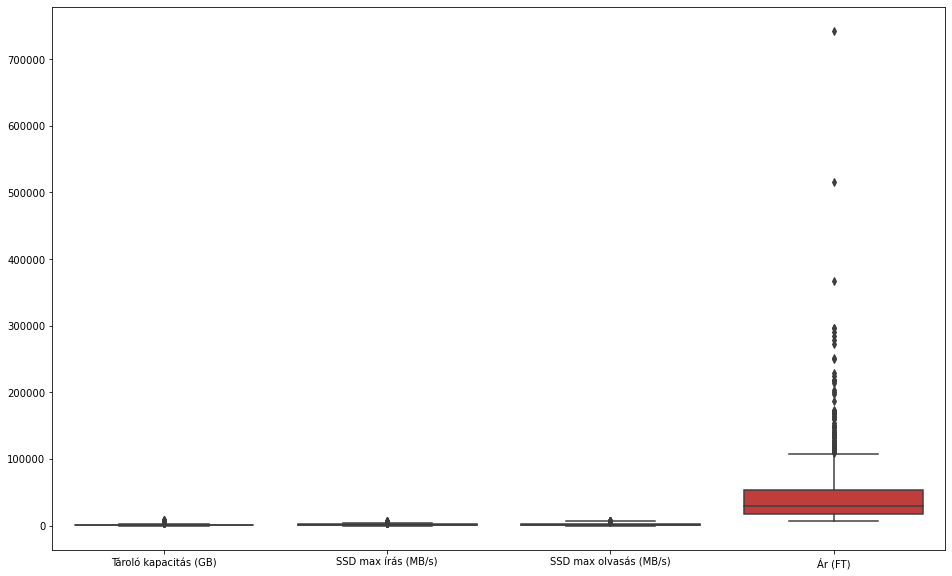

In [279]:
plt.figure(figsize=(16, 10))
num_cols = ['Tároló kapacitás (GB)', 'SSD max írás (MB/s)', 'SSD max olvasás (MB/s)', 'Ár (FT)']
sns.boxplot(data=df_droped[num_cols])

<AxesSubplot:>

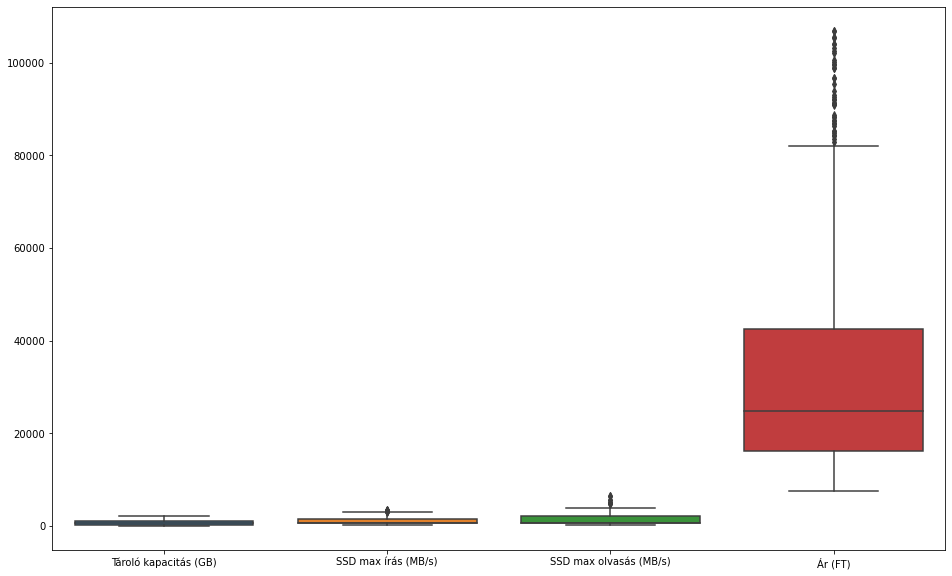

In [280]:
Q1 = df_droped[num_cols].quantile(0.25)
Q3 = df_droped[num_cols].quantile(0.75)
IQR = Q3 - Q1

df_filtered = df_droped[~((df_droped[num_cols] < (Q1 - 1.5 * IQR)) | (df_droped[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

plt.figure(figsize=(16, 10))
sns.boxplot(data=df_filtered[num_cols])

In [281]:
df_filtered.shape

(630, 10)

<AxesSubplot:>

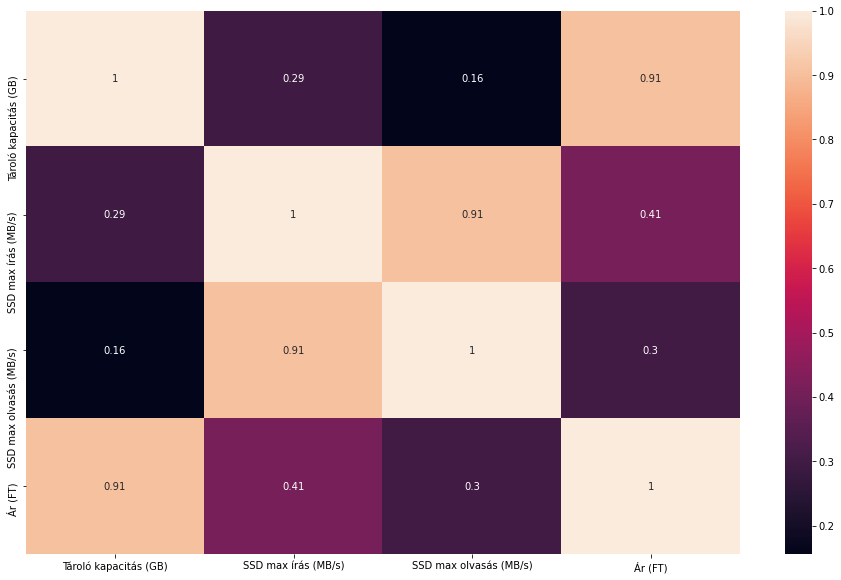

In [282]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_filtered.corr(), annot=True)

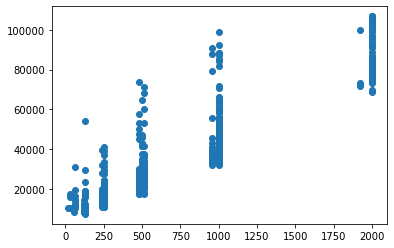

In [283]:
plt.scatter(df_filtered['Tároló kapacitás (GB)'], df_filtered['Ár (FT)'])

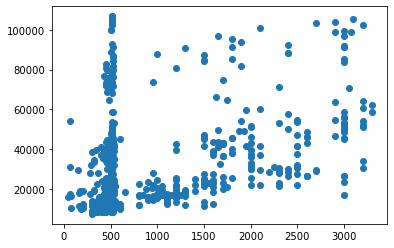

In [284]:
plt.scatter(df_filtered['SSD max írás (MB/s)'], df_filtered['Ár (FT)'])

### Kategorikus mezők 


In [285]:
df_filtered.head()

,Megnevezés,Méret,Csatlakozás,Technológia,Tároló kapacitás (GB),SSD max írás (MB/s),SSD max olvasás (MB/s),Világítás,Hűtőborda,Ár (FT)
0,"KINGSTON 240GB A400 SATA 3 2.5"" SA400S37/240G","2.5""",SATA 3,TLC,240,350,500,Nem,Nem,11890
1,KINGSTON 500GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,500,2000,2200,Nem,Nem,22189
2,"KINGSTON 480GB A400 SATA 3 2.5"" SA400S37/480G","2.5""",SATA 3,TLC,480,450,500,Nem,Nem,18090
3,KINGSTON 250GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,250,1100,2000,Nem,Nem,14489
4,KINGSTON 1TB A2000 M.2 PCIe M.2 2280 SA2000M8/...,M.2 2280,M.2 PCIe,TLC,1000,2000,2200,Nem,Nem,39590


In [286]:
X = df_filtered.iloc[:, 1: -1]
y = df_filtered.iloc[:, -1]
y = y.values.reshape(-1, 1)

In [287]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(X[['Méret', 'Csatlakozás', 'Technológia', 'Világítás', 'Hűtőborda']]))

# One-hot encoding removed index; put it back
OH_cols.index = X.index


num_X = X.drop(['Méret', 'Csatlakozás', 'Technológia', 'Világítás', 'Hűtőborda'], axis=1)

# Add one-hot encoded columns to numerical features
OH_X = pd.concat([num_X, OH_cols], axis=1)
OH_X

,Tároló kapacitás (GB),SSD max írás (MB/s),SSD max olvasás (MB/s),0,1,2,3,4,5,6,...,13,14,15,16,17,18,19,20,21,22
0,240,350,500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,500,2000,2200,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,480,450,500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,250,1100,2000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1000,2000,2200,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,250,1300,1700,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
716,500,1750,2400,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
717,128,540,560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
718,256,540,560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [288]:
OH_encoder.transform(np.array(['2.5"', 'SATA 3', 'TLC', 'Nem', 'Nem']).reshape(-1, 5))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 1.]])

In [289]:
OH_encoder.inverse_transform([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 1.]])

array([['2.5"', 'SATA 3', 'TLC', 'Nem', 'Nem']], dtype=object)

### Tanító és teszt halmazra darabolás

In [314]:
X_train, X_test, y_train, y_test = train_test_split(OH_X.values, y, test_size=0.3, random_state=41)

### Standardizálás

In [315]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc2 = StandardScaler()
X_train[:, :3] = sc.fit_transform(X_train[:, :3])
X_test[:, :3] = sc.transform(X_test[:, :3])
y_train = sc2.fit_transform(y_train)
y_test = sc2.transform(y_test)

In [316]:
y_test[0]

array([-0.08823952])

## Modellek

### Linear regression

In [336]:
linear = LinearRegression()
results = cross_val_score(estimator=linear, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('r2 scoe: {:.2f}'.format(results.mean()))

r2 scoe: 0.86


In [338]:
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

#mean_squared_error(y_test, y_pred)
print('r2 scoe: {:.3f}'.format(linear.score(X_test, y_test)))

r2 scoe: 0.844


In [339]:
results.std()

0.0672305433655424

### Decision tree regressor

In [320]:
tree = DecisionTreeRegressor()
results = cross_val_score(estimator=tree, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('r2 scoe: {:.2f}'.format(results.mean()))

r2 scoe: 0.81


Hyperparameter tuning

In [321]:
parameters = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
}

grid_search = GridSearchCV(estimator = tree,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = 10,
                           return_train_score = True,
                           n_jobs = -1)

grid_search.fit(X_train, y_train.ravel())
best_r2 = grid_search.best_score_
best_parameters = grid_search.best_params_
print()
print("Best r2: {:.2f}".format(best_r2))
print("Best Parameters:", best_parameters)
print()


Best r2: 0.51
Best Parameters: {'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8}



In [322]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

#mean_squared_error(y_test, y_pred)
print('r2 scoe: {:.3f}'.format(tree.score(X_test, y_test)))

r2 scoe: 0.828


### Random forest regressor

In [323]:
forest = RandomForestRegressor()
results = cross_val_score(estimator=forest, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('r2 scoe: {:.2f}'.format(results.mean()))

r2 scoe: 0.85


Hyperparameter tuning

In [324]:
parameters = {
    'max_depth': [None, 10, 15, 20, 30, 50],
    'max_features': [None, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [1, 2, 8, 10, 12]
}

grid_search = GridSearchCV(estimator = forest,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = 10,
                           return_train_score = True,
                           n_jobs = -1)

grid_search.fit(X_train, y_train.ravel())
best_r2 = grid_search.best_score_
best_parameters = grid_search.best_params_
print()
print("Best r2: {:.3f}".format(best_r2))
print("Best Parameters:", best_parameters)
print()

SyntaxError: invalid syntax (<ipython-input-324-23d5d6367af1>, line 4)

In [333]:
forest = RandomForestRegressor(n_estimators=100, max_depth=110, min_samples_split=5)
forest.fit(X_train, y_train.ravel())
y_pred = forest.predict(X_test)

#mean_squared_error(y_test, y_pred)
print('r2 scoe: {:.3f}'.format(forest.score(X_test, y_test)))

r2 scoe: 0.843


In [327]:
forest = RandomForestRegressor(n_estimators=100, max_depth=110, min_samples_split=5)
results = cross_val_score(estimator=forest, X=X_test, y=y_test, cv=10, n_jobs=-1)
print('r2 scoe: {:.2f}'.format(results.mean()))

r2 scoe: 0.77


### Support vector regressor

In [328]:
svr = SVR()
results = cross_val_score(estimator=svr, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('r2 scoe: {:.2f}'.format(results.mean()))

r2 scoe: 0.85


Hyperparameter tuning

In [329]:
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search = GridSearchCV(estimator = svr,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = 10,
                           return_train_score = True,
                           n_jobs = -1)

grid_search.fit(X_train, y_train.ravel())
print("Best r2: {:.2f}".format(grid_search.best_score_))
print("Best Parameters:", grid_search.best_params_)

Best r2: 0.85
Best Parameters: {'C': 0.5, 'kernel': 'linear'}


In [330]:
svr = SVR(kernel='linear', C=0.5)
svr.fit(X_train, y_train.ravel())
y_pred = svr.predict(X_test)

#mean_squared_error(y_test, y_pred)
print('r2 scoe: {:.3f}'.format(svr.score(X_test, y_test)))

r2 scoe: 0.837


### Predict

In [114]:
#OH_encoder.transform(np.array(['2.5"', 'SATA 3', 'TLC', 'Nem', 'Nem']).reshape(-1, 5))

Ha minden mezo skalazva van.

In [331]:
num_values = sc.transform([[250, 1100, 2000]])
cat_values = OH_encoder.transform(np.array(['M.2 2280', 'M.2 PCIe', 'TLC', 'Nem', 'Nem']).reshape(-1, 5))
#cat_values = OH_encoder.transform(np.array(['M.2 PCIe']).reshape(-1, 1))

array = []
for i in num_values:
    for j in i:
        array.append(j)
for i in cat_values:
    for j in i:
        array.append(j)
array

result = svr.predict([array])
sc2.inverse_transform(result)

array([15580.21656089])

In [334]:
forest.predict([array])

array([-0.71421476])

In [649]:
sc2.inverse_transform([-0.67402511])

array([16799.04508357])

In [591]:
df_filtered

,Megnevezés,Méret,Csatlakozás,Technológia,Tároló kapacitás (GB),SSD max írás (MB/s),SSD max olvasás (MB/s),TBW (TB),Világítás,Hűtőborda,Ár (FT)
0,"KINGSTON 240GB A400 SATA 3 2.5"" SA400S37/240G","2.5""",SATA 3,TLC,240,350,500,80,Nem,Nem,11890
1,KINGSTON 500GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,500,2000,2200,300,Nem,Nem,22189
2,"KINGSTON 480GB A400 SATA 3 2.5"" SA400S37/480G","2.5""",SATA 3,TLC,480,450,500,160,Nem,Nem,18090
3,KINGSTON 250GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,250,1100,2000,150,Nem,Nem,14489
4,KINGSTON 1TB A2000 M.2 PCIe M.2 2280 SA2000M8/...,M.2 2280,M.2 PCIe,TLC,1000,2000,2200,600,Nem,Nem,39590
...,...,...,...,...,...,...,...,...,...,...,...
715,WD 250GB Blue SN500 NVMe M.2 PCIe M.2 2280 WDS...,M.2 2280,M.2 PCIe,TLC,250,1300,1700,150,Nem,Nem,19590
722,WD 500GB Blue SN550 NVMe M.2 PCIe M.2 2280 WDB...,M.2 2280,M.2 PCIe,TLC,500,1750,2400,300,Nem,Nem,64690
723,"ZADAK 128GB TWSS3 SATA 3 2.5"" ZS128GTWSS3-1","2.5""",SATA 3,TLC,128,540,560,0,Nem,Nem,10690
724,"ZADAK 256GB TWSS3 SATA 3 2.5"" ZS256GTWSS3-1","2.5""",SATA 3,TLC,256,540,560,0,Nem,Nem,14089


Ha nincsenek skálázva az adatok.

In [178]:
array = [480, 450, 500]
asd = OH_encoder.transform(np.array(['2.5"', 'SATA 3', 'TLC', 'Nem', 'Nem']).reshape(-1, 5))
#asd = OH_encoder.transform(np.array(['SATA 3']).reshape(-1, 1))

for i in asd:
    for j in i:
        array.append(j)
#array

In [317]:
linear.predict([array])

array([[11292302.32448463]])

In [101]:
sc.transform([[480, 450, 500, 160]])

array([[-0.26354206, -0.61958195, -0.66794449, -0.2704257 ]])

In [354]:
np.concatenate((X_train, X_test), axis=0).shape

(617, 27)

In [253]:
df_filtered['Tároló kapacitás (GB)'].max()

2000

In [48]:
#Best r2: 0.85
#Best Parameters: {'max_depth': 110, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Adatok és objektumok kimentése publikáláshoz

In [340]:
filenames = ['finalized_model.sav', 'sc_X.sav', 'sc_y.sav', 'oh_enc.sav']
objects = [linear, sc, sc2, OH_encoder]
for i in range(len(filenames)):
    pickle.dump(objects[i], open(filenames[i], 'wb'))

df_filtered.to_csv('prepeared_data.csv', index=False, encoding='utf-8')

In [189]:
filename = 'finalized_model.sav'
pickle.dump(forest, open(filename, 'wb'))

In [182]:
filename = 'sc_y.sav'
pickle.dump(sc2, open(filename, 'wb'))

In [183]:
filename = 'sc_X.sav'
pickle.dump(sc, open(filename, 'wb'))

In [184]:
filename = 'oh_enc.sav'
pickle.dump(OH_encoder, open(filename, 'wb'))

In [185]:
sc2.inverse_transform([[-0.51533502]])[0][0]

21383.662611255673

In [341]:
asd = df_filtered[df_filtered[['Méret', 'Csatlakozás', 'Technológia']].duplicated() == False]
asd[['Méret', 'Csatlakozás', 'Technológia']]

,Méret,Csatlakozás,Technológia
0,"2.5""",SATA 3,TLC
1,M.2 2280,M.2 PCIe,TLC
5,M.2 2280,M.2 PCIe,MLC
7,M.2 2280,M.2 PCIe,Optane
8,mSATA,mSATA,MLC
11,"2.5""",SATA 3,MLC
33,"2.5""",SATA 3,QLC
38,M.2 2280,M.2 SATA,TLC
39,M.2 2280,M.2 PCIe,QLC
51,M.2 2280,M.2 SATA,MLC


In [192]:
df_filtered[df_filtered[['Méret', 'Csatlakozás', 'Technológia']].duplicated() == False]

,Megnevezés,Méret,Csatlakozás,Technológia,Tároló kapacitás (GB),SSD max írás (MB/s),SSD max olvasás (MB/s),Világítás,Hűtőborda,Ár (FT)
0,"KINGSTON 240GB A400 SATA 3 2.5"" SA400S37/240G","2.5""",SATA 3,TLC,240,350,500,Nem,Nem,11890
1,KINGSTON 500GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,500,2000,2200,Nem,Nem,22189
5,SAMSUNG 500GB 970 EVO Plus M.2 PCIe M.2 2280 M...,M.2 2280,M.2 PCIe,MLC,500,3200,3500,Nem,Nem,30390
7,INTEL 256GB Optane H10 M.2 PCIe M.2 2280 HBRPE...,M.2 2280,M.2 PCIe,Optane,256,650,1450,Nem,Nem,18790
8,TRANSCEND 32GB MSA370 mSATA TS32GMSA370,mSATA,mSATA,MLC,32,40,260,Nem,Nem,15890
11,"SAMSUNG 500GB 860 EVO SATA 3 2.5"" MZ-76E500B/E...","2.5""",SATA 3,MLC,500,520,550,Nem,Nem,28090
33,"SAMSUNG 1TB 870 QVO SATA 3 2.5"" MZ-77Q1T0BW","2.5""",SATA 3,QLC,1000,520,550,Nem,Nem,36690
38,WD 500GB Blue M.2 SATA M.2 2280 WDS500G2B0B,M.2 2280,M.2 SATA,TLC,500,530,560,Nem,Nem,19690
39,INTEL 512GB 660P M.2 PCIe M.2 2280 SSDPEKNW512...,M.2 2280,M.2 PCIe,QLC,512,1000,1500,Nem,Nem,20490
51,SAMSUNG 250GB 860 EVO M.2 SATA M.2 2280 MZ-N6E...,M.2 2280,M.2 SATA,MLC,250,520,550,Nem,Nem,17990


In [187]:
df_filtered.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
709    False
716    False
717    False
718    False
719    False
Length: 630, dtype: bool